Check Python version

In [294]:
!python --version

Python 3.10.6


Import libraries

In [295]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [296]:
# Local directory
data_dir = "../datasets/climate"
file_name = "temp_anom_w_forcing"
#data_dir = "../datasets/finance"
#file_name = "Returns_short_interest_data_train"
file_path = f"{data_dir}/{file_name}.csv"

# Through online GitHub
# file_path = "https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv"

In [297]:
dataset = pd.read_csv(file_path)

In [298]:
dataset.shape

(163, 11)

In [299]:
dataset.columns

Index(['Year', 'WMGHG', 'Ozone', 'Solar', 'Land_Use', 'SnowAlb_BC', 'Orbital',
       'TropAerDir', 'TropAerInd', 'StratAer', 'Anomaly'],
      dtype='object')

In [300]:
dataset.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12


In [301]:
dataset.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
158,2008,3.36688,0.451834,-0.009377,-0.205278,0.053937,0.002234,-0.189395,-0.697385,0.059742,0.55
159,2009,3.40963,0.451834,-0.006203,-0.205278,0.053937,0.002241,-0.189395,-0.697385,0.040626,0.66
160,2010,3.45082,0.451834,0.020822,-0.205278,0.053937,0.002254,-0.189395,-0.697385,0.081508,0.73
161,2011,3.49278,0.451834,0.058369,-0.205278,0.053937,0.002261,-0.189395,-0.697385,0.088224,0.62
162,2012,3.53407,0.451834,0.095752,-0.205278,0.053937,0.002277,-0.189395,-0.697385,0.088224,0.66


In [302]:
time_col = dataset.columns[0]
target_col = dataset.columns[-1]
dataset[time_col] = dataset[time_col].astype(str)

Change 'target' to float

In [303]:
# dataset[target_col] = dataset[target_col].astype(float)

In [304]:
# dataset.head()

In [305]:
training_points = int(0.8*len(dataset))
train_df = dataset.iloc[:training_points]
test_df = dataset.iloc[training_points:]

Plot graph

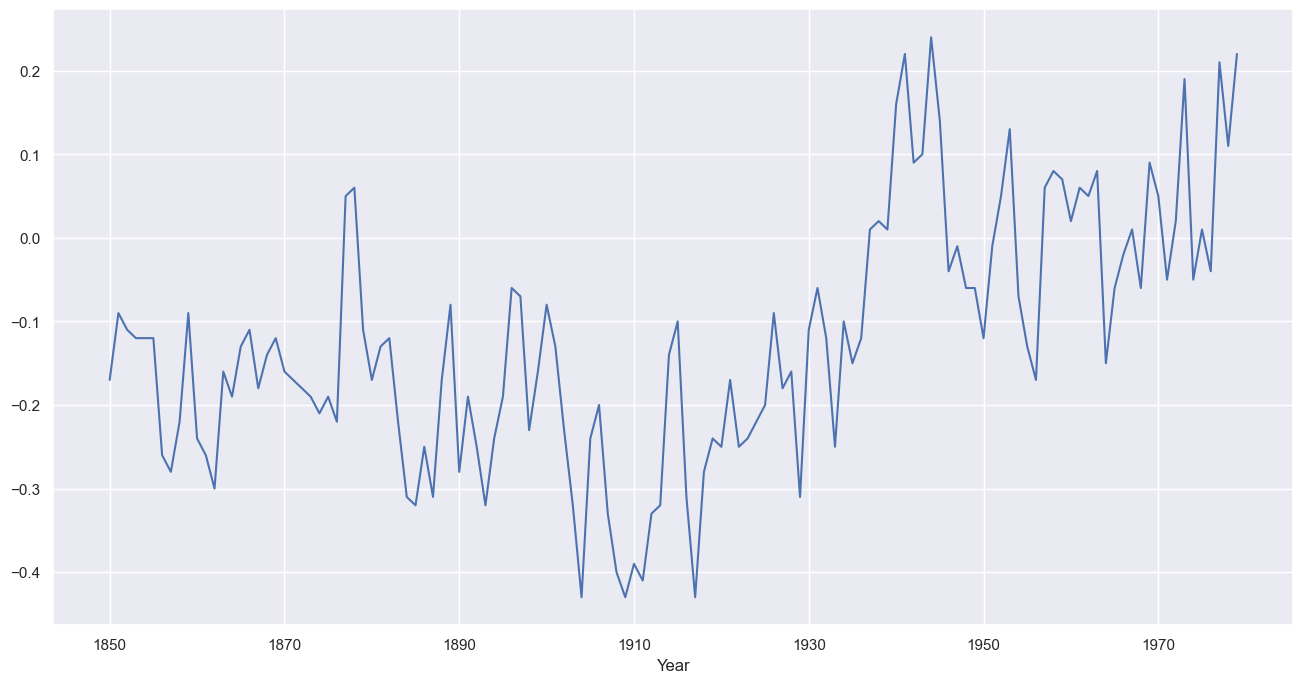

In [306]:
figsize = (16, 8)
train_df.set_index(time_col)[target_col].plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [307]:
train_data = []
for value in train_df.values:
    train_data.append(list(value))

In [308]:
train_data[:2]

[['1850', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.17],
 ['1851',
  0.00595381,
  0.0007451,
  0.00116604,
  -0.0009399,
  0.00064918,
  0.00065287,
  0.00064918,
  -4.97297e-06,
  0.0290878,
  -0.09]]

Custom Model Request (optional)

In [309]:
custom_model_request_dict = {
    'type': 'meta_wa',
    'score': ['smape', 'mape'],
    'param': {
        'base_models': [
            {'type': 'darts_autoarima'},
            {'type': 'darts_autotheta'},
            {'type': 'darts_autoets'},
            {'type': 'stats_autotheta'},
        ]
    }
}

In [310]:
custom_model_request = json.dumps(custom_model_request_dict)

Train API JSON Payload

In [311]:
api_json = {
    'data': train_data,
    # 'model': custom_model_request,  # TODO: custom_model_request_dict returns empty JSON output
}

Build URL

In [312]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [313]:
# URL to our SYBIL AWS service
protocol = url_dict["protocol"]
host = url_dict["host"]
port = url_dict["port"]
endpoint = "train"

url = "%s://%s:%s/%s" % (protocol, host, str(port), endpoint)

In [314]:
protocol, host, port

('http', 'localhost', 80)

Call endpoint, receive response JSON, write to output file

In [315]:
%%time
# TODO: gain a accredited cert and remove verify=False
response = requests.post(url, json=api_json, verify=False)

CPU times: total: 15.6 ms
Wall time: 9.9 s


In [316]:
train_json_out = response.json()  # dict output
# train_json_out = json.dumps(response.json())  # str output
# train_json_out = json.dumps(response.json(), indent=4)  # str output w tabs

In [317]:
train_json_out

{'model': 'AgEBCEnXAABI1wAAir0AABgAAACFvQAAhBgAAD+AAC5tcE1slHNzDGEpZGRybGFmdHRzU5RuaXJzCmmUaR+MA2FycmGUlHIYeWGMYZMolGRhcmlueHSUcmFyZWludB94REl9YWEujHVfQpRzcnSMbZOHbXlNlE5KlAGUbS5yZQVjB5QBS4yADx8AcuJSwjKiE4PzY9NDsyOTBHTkVMQ0pBSF9WXVRbUllR8GduZWxjamFof3Z9dHtyeXB3joWMg4qBiI+GjYSbkpmR8JeelZyTqqGor6atpKuiqbC3vrW8s7qxuM/GzcTLwsnB8Nfe1dzT2tHY7+bt5Ovi6eD3/vX88/rx+PAHDgUMAwoB8QgPCMTmGUeZRyZZQJbk6FlBhjZWVflGVohShAhwH/SxmMYlJVlE6UfZRvaX1hcmVklJR4KLiUAJRoAOB4AB+UX3N0ZglpS1+UlGiUGF9DkmgoAJRodIZodZRpjGxOaB9sTFBLaIho/wAAxbe8vr6+0NHMt87Q08TIwLzHwb7ExR/HyMrIzKmuvMXAvszT1NDTxbTRyNDUzsiusc3EtMDN1B/bzsnV2dvY2tXUwbnT29HO0MXQzszJt8fE07yuvtC5wx++hJSExMy3uc7BpISurr6EqcCxwMWutLGUrqm0w66UhB+ut6mplMiphKTKvMx9dHKMY05iX6pkX2hyjJRsbU5vXx9uFXZzjF90c19wYYlfdpRlcmkXdXaUc3R2lGVpaRd0dh+UX4hslGMLRFJfc3N0TmVycG5lZGVslChiaHSJc3VfTgZ0bIxuYXRzYDUTX3aUX2NlYWQQb3MoAJRoaIxlcmbACh90bWZyZW1zZWR1lOeMZIxqbyhrcZS8aGEIQGHMbQCsUh+UQ4MDdGOUdGiHAo+GlPFMUEuJCysVeB0RlGlMUEsQXh+6nK8nsoMNO0w8T277fFnbm5VJBAV/7SUe7jceR0D+RR/IzaCtQ3dVHFIl0qcPl

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [318]:
test_data = []
for value in test_df.drop(columns=target_col).values:
    test_data.append(list(value))

In [319]:
test_data[:2]

[['1980',
  2.09837,
  0.362496,
  0.132923,
  -0.197799,
  0.0534377,
  0.00195668,
  -0.116014,
  -0.557516,
  -0.0294989],
 ['1981',
  2.15487,
  0.37198,
  0.13994,
  -0.198391,
  0.0534899,
  0.00196222,
  -0.12073,
  -0.572096,
  -0.0378411]]

Model from Train API

In [320]:
model = train_json_out["model"]

Forecast API JSON Payload

In [321]:
api_json = {
    'model': model,
    'predicts': test_data
}

Build URL (same as train except for the endpoint)

In [322]:
endpoint = "forecast"

url = "%s://%s:%s/%s" % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [323]:
%%time
# TODO: gain a accredited cert and remove verify=False
response = requests.post(url, json=api_json, verify=False)

CPU times: total: 0 ns
Wall time: 47.8 ms


In [324]:
forecast_json_out = response.json()  # dict output
# forecast_json_out = json.dumps(response.json())  # str output
# forecast_json_out = json.dumps(response.json(), indent=4)  # str output w tabs

In [325]:
forecast_json_out

{'data': [['1980-01-01T00:00:00', 0.4529357245923602],
  ['1980-12-31T00:00:00', 0.7890899435897163],
  ['1981-12-31T00:00:00', 0.6854112718226455],
  ['1982-12-31T00:00:00', 0.6555279815316202],
  ['1983-12-31T00:00:00', 0.519602090425471],
  ['1984-12-30T00:00:00', 0.8853376001208075],
  ['1985-12-30T00:00:00', 0.7871100860269513],
  ['1986-12-30T00:00:00', 0.784471539513711],
  ['1987-12-30T00:00:00', 0.6348814913050509],
  ['1988-12-29T00:00:00', 0.9997878889804728],
  ['1989-12-29T00:00:00', 0.8960270099757501],
  ['1990-12-29T00:00:00', 0.8538781883615614],
  ['1991-12-29T00:00:00', 0.6805846116302576],
  ['1992-12-28T00:00:00', 1.0461627974173449],
  ['1993-12-28T00:00:00', 0.9370898136788879],
  ['1994-12-28T00:00:00', 0.9208421826544448],
  ['1995-12-28T00:00:00', 0.7553892201770329],
  ['1996-12-27T00:00:00', 1.1059213041567828],
  ['1997-12-27T00:00:00', 1.0022136777769406],
  ['1998-12-27T00:00:00', 0.9905345414043061],
  ['1999-12-27T00:00:00', 0.8341992737833956],
  ['200

Combine forecast dates and output

In [326]:
forecast_df = pd.DataFrame(forecast_json_out["data"], columns = [time_col, target_col])

In [327]:
forecast_df.shape

(33, 2)

In [328]:
forecast_df.columns

Index(['Year', 'Anomaly'], dtype='object')

In [329]:
forecast_df.head()

,Year,Anomaly
0,1980-01-01T00:00:00,0.452936
1,1980-12-31T00:00:00,0.789090
2,1981-12-31T00:00:00,0.685411
3,1982-12-31T00:00:00,0.655528
4,1983-12-31T00:00:00,0.519602


In [330]:
forecast_df.tail()

,Year,Anomaly
28,2007-12-25T00:00:00,0.945351
29,2008-12-24T00:00:00,1.295956
30,2009-12-24T00:00:00,1.187286
31,2010-12-24T00:00:00,1.171123
32,2011-12-24T00:00:00,1.010445


Plot train and forecast side-by-side

C:\Users\User\AppData\Local\Temp\ipykernel_25724\28132996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["color"] = "b"


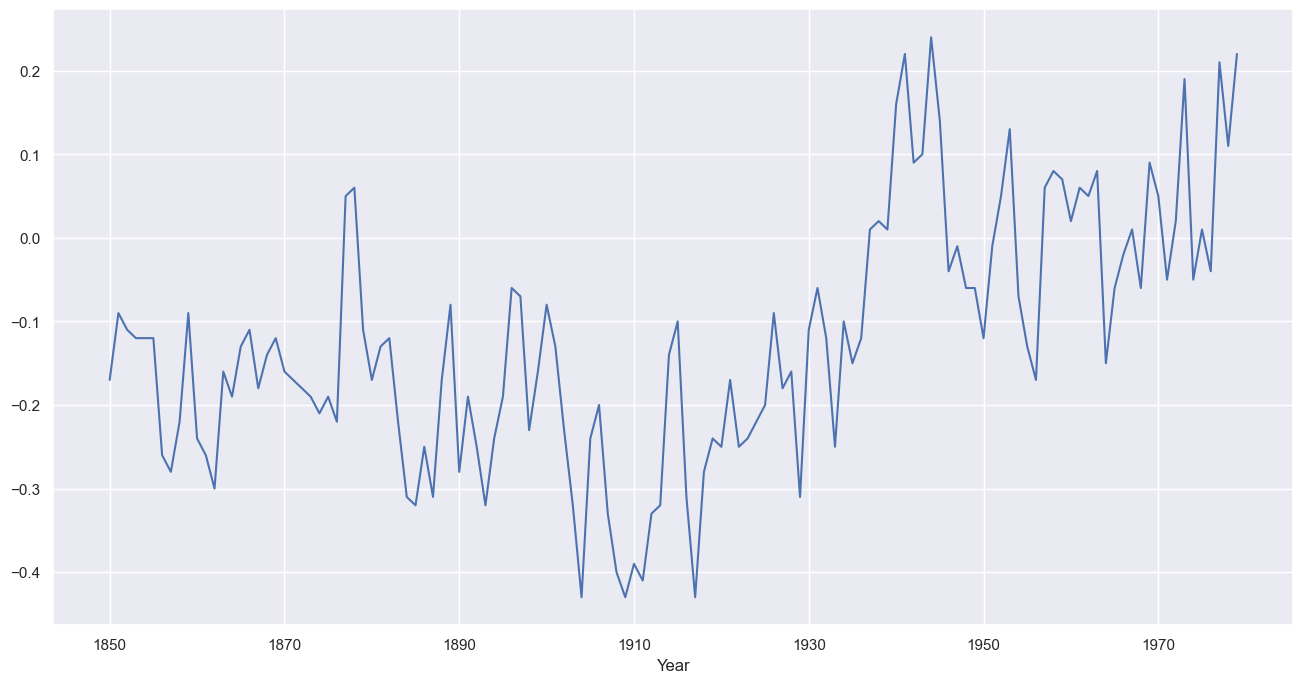

In [331]:
train_df["color"] = "b"
train_df.set_index(time_col)[target_col].plot(figsize=figsize, color=train_df["color"]);

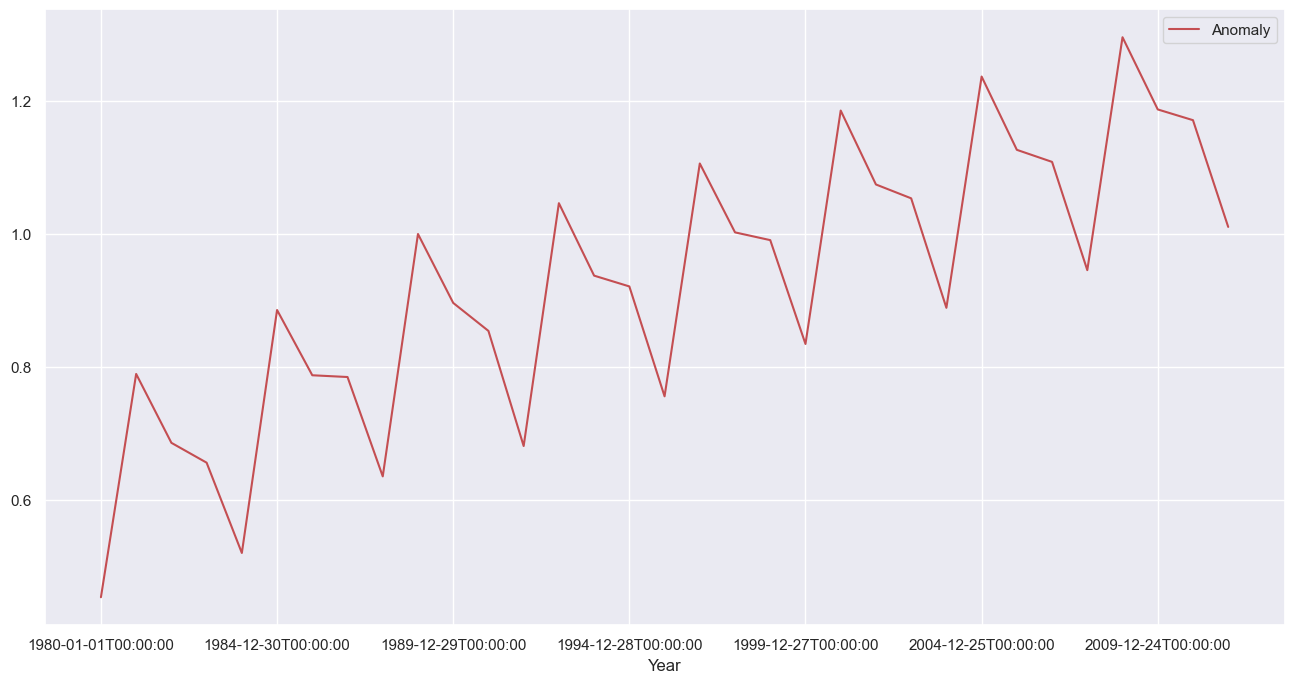

In [332]:
forecast_df["color"] = "r"
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df["color"]);

Combine train and test sets

In [333]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [334]:
df.shape

(163, 12)

In [335]:
df.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17,b
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09,b
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11,b
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12,b
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12,b


In [336]:
df.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color
158,2007-12-25T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.945351,r
159,2008-12-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.295956,r
160,2009-12-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.187286,r
161,2010-12-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.171123,r
162,2011-12-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.010445,r


Plot combined train and test sets with the vertical black line as the cut-off

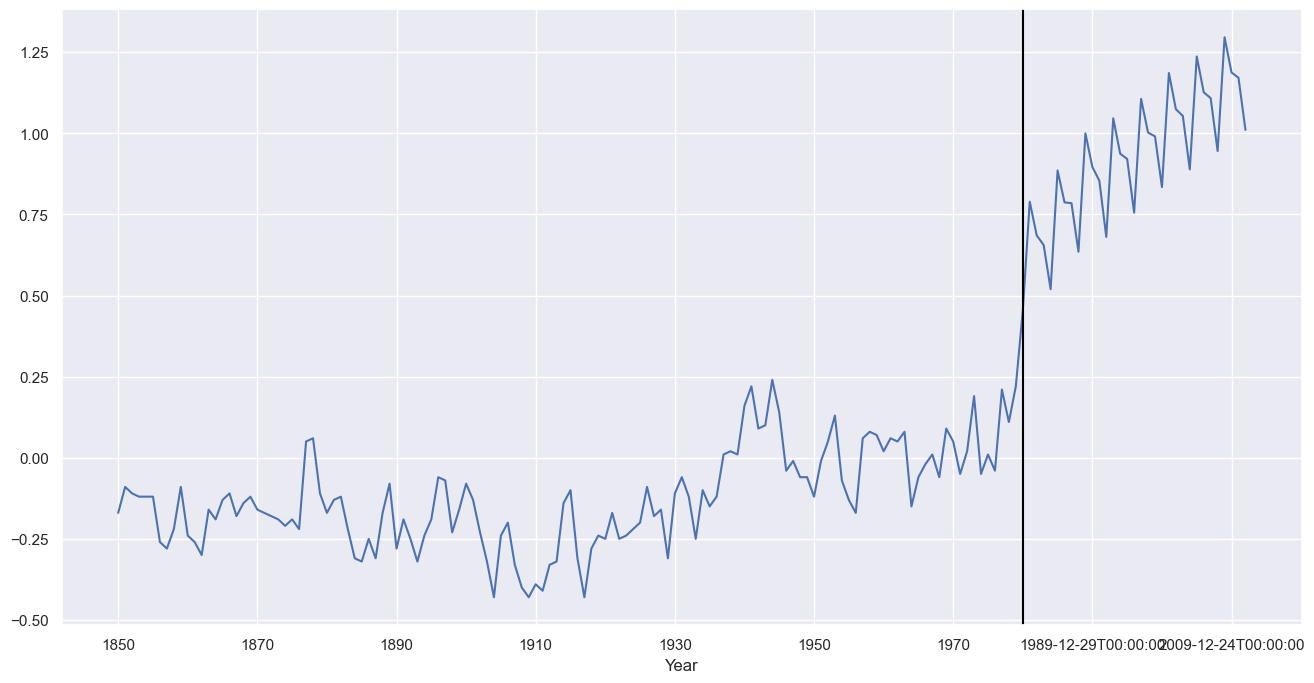

In [337]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color=df["color"])
plt.axvline(x=len(train_df), color='black', label ='Train/Test set cut-off')
plt.show();